In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [2]:

p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

In [5]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 6644
Total Drives: 172014
Total Plays: 1210147


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 171110


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety","placeholder","End of Period"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [8]:
# %%timeit
if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep, axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
1,1,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
2,2,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
4,4,322430009005,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,11,47,3,6.0,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,2.359414,2012,0.476408
5,5,322430009004,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,53,46,2,7.0,1,Rush,Cameron Marshall rush for 1 yard to the ArzSt 47.,-0.876000,2012,0.048068


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [11]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_special_teams_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types)) & (pbp.offense == team)]
    fg_plays = st_plays[st_plays.play_type.str.contains('Field Goal')]
    kickoff_plays = st_plays[st_plays.play_type.str.contains('Kickoff')]
    punt_plays = st_plays[st_plays.play_type.str.contains('Punt')]
    
    fg_eff = verify_division(fg_plays[fg_plays.play_type.str.contains('Good')], len(fg_plays))
    #kick_returns = kickoff_plays[kickoff_plays.play_type.str.contains("Return")]
    # regex for kickoff air yards "kickoff for /d yds"
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
#         'PuntSR': [],
#         'KickoffSR': []
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)
    # return translate(team_stat_pack.OppSRDiff, -1, 1, 0, ((5.83 + 3.38)/2.0)) + translate(team_stat_pack.IsoPPPDiff, -1, 1, 0, ((4.17+4.41)/2.0)) + translate(team_stat_pack.OffSRDiff, -1, 1, 0, ((4.17+2.21)/2))

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(100, (x.yard_line)), 0)].ep, axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [12]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 4973 box score groups by GameID.
[1/4973] Updating 5FR Margin for game_id 322430041...
[1/4973] Updated 5FR Margin for game_id 322430041.
[2/4973] Updating 5FR Margin for game_id 322430238...
[2/4973] Updated 5FR Margin for game_id 322430238.
[3/4973] Updating 5FR Margin for game_id 322430242...
[3/4973] Updated 5FR Margin for game_id 322430242.
[4/4973] Updating 5FR Margin for game_id 322430252...
[4/4973] Updated 5FR Margin for game_id 322430252.
[5/4973] Updating 5FR Margin for game_id 322432006...
[5/4973] Updated 5FR Margin for game_id 322432006.
[6/4973] Updating 5FR Margin for game_id 322432050...
[6/4973] Updated 5FR Margin for game_id 322432050.
[7/4973] Updating 5FR Margin for game_id 322432439...
[7/4973] Updated 5FR Margin for game_id 322432439.
[8/4973] Updating 5FR Margin for game_id 322440024...
[8/

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[234/4973] Updating 5FR Margin for game_id 322800024...
[234/4973] Updated 5FR Margin for game_id 322800024.
[235/4973] Updating 5FR Margin for game_id 322800025...
[235/4973] Updated 5FR Margin for game_id 322800025.
[236/4973] Updating 5FR Margin for game_id 322800036...
[236/4973] Updated 5FR Margin for game_id 322800036.
[237/4973] Updating 5FR Margin for game_id 322800057...
[237/4973] Updated 5FR Margin for game_id 322800057.
[238/4973] Updating 5FR Margin for game_id 322800084...
[238/4973] Updated 5FR Margin for game_id 322800084.
[239/4973] Updating 5FR Margin for game_id 322800087...
[239/4973] Updated 5FR Margin for game_id 322800087.
[240/4973] Updating 5FR Margin for game_id 322800096...
[240/4973] Updated 5FR Margin for game_id 322800096.
[241/4973] Updating 5FR Margin for game_id 322800120...
[241/4973] Updated 5FR Margin for game_id 322800120.
[242/4973] Updating 5FR Margin for game_id 322800142...
[242/4973] Updated 5FR Margin for game_id 322800142.
[243/4973] Updatin

[472/4973] Updating 5FR Margin for game_id 323080204...
[472/4973] Updated 5FR Margin for game_id 323080204.
[473/4973] Updating 5FR Margin for game_id 323080239...
[473/4973] Updated 5FR Margin for game_id 323080239.
[474/4973] Updating 5FR Margin for game_id 323080249...
[474/4973] Updated 5FR Margin for game_id 323080249.
[475/4973] Updating 5FR Margin for game_id 323080254...
[475/4973] Updated 5FR Margin for game_id 323080254.
[476/4973] Updating 5FR Margin for game_id 323080276...
[476/4973] Updated 5FR Margin for game_id 323080276.
[477/4973] Updating 5FR Margin for game_id 323080277...
[477/4973] Updated 5FR Margin for game_id 323080277.
[478/4973] Updating 5FR Margin for game_id 323080278...
[478/4973] Updated 5FR Margin for game_id 323080278.
[479/4973] Updating 5FR Margin for game_id 323080328...
[479/4973] Updated 5FR Margin for game_id 323080328.
[480/4973] Updating 5FR Margin for game_id 323080344...
[480/4973] Updated 5FR Margin for game_id 323080344.
[481/4973] Updating

[711/4973] Updated 5FR Margin for game_id 332430245.
[712/4973] Updating 5FR Margin for game_id 332430251...
[712/4973] Updated 5FR Margin for game_id 332430251.
[713/4973] Updating 5FR Margin for game_id 332430258...
[713/4973] Updated 5FR Margin for game_id 332430258.
[714/4973] Updating 5FR Margin for game_id 332430259...
[714/4973] Updated 5FR Margin for game_id 332430259.
[715/4973] Updating 5FR Margin for game_id 332430264...
[715/4973] Updated 5FR Margin for game_id 332430264.
[716/4973] Updating 5FR Margin for game_id 332430275...
[716/4973] Updated 5FR Margin for game_id 332430275.
[717/4973] Updating 5FR Margin for game_id 332430276...
[717/4973] Updated 5FR Margin for game_id 332430276.
[718/4973] Updating 5FR Margin for game_id 332432132...
[718/4973] Updated 5FR Margin for game_id 332432132.
[719/4973] Updating 5FR Margin for game_id 332432294...
[719/4973] Updated 5FR Margin for game_id 332432294.
[720/4973] Updating 5FR Margin for game_id 332432572...
[720/4973] Updated 

[958/4973] Updated 5FR Margin for game_id 332842132.
[959/4973] Updating 5FR Margin for game_id 332850008...
[959/4973] Updated 5FR Margin for game_id 332850008.
[960/4973] Updating 5FR Margin for game_id 332850009...
[960/4973] Updated 5FR Margin for game_id 332850009.
[961/4973] Updating 5FR Margin for game_id 332850026...
[961/4973] Updated 5FR Margin for game_id 332850026.
[962/4973] Updating 5FR Margin for game_id 332850036...
[962/4973] Updated 5FR Margin for game_id 332850036.
[963/4973] Updating 5FR Margin for game_id 332850041...
[963/4973] Updated 5FR Margin for game_id 332850041.
[964/4973] Updating 5FR Margin for game_id 332850061...
[964/4973] Updated 5FR Margin for game_id 332850061.
[965/4973] Updating 5FR Margin for game_id 332850096...
[965/4973] Updated 5FR Margin for game_id 332850096.
[966/4973] Updating 5FR Margin for game_id 332850099...
[966/4973] Updated 5FR Margin for game_id 332850099.
[967/4973] Updating 5FR Margin for game_id 332850113...
[967/4973] Updated 

[1201/4973] Updating 5FR Margin for game_id 333132641...
[1201/4973] Updated 5FR Margin for game_id 333132641.
[1202/4973] Updating 5FR Margin for game_id 333132751...
[1202/4973] Updated 5FR Margin for game_id 333132751.
[1203/4973] Updating 5FR Margin for game_id 333160189...
[1203/4973] Updated 5FR Margin for game_id 333160189.
[1204/4973] Updating 5FR Margin for game_id 333162649...
[1204/4973] Updated 5FR Margin for game_id 333162649.
[1205/4973] Updating 5FR Margin for game_id 333172309...
[1205/4973] Updated 5FR Margin for game_id 333172309.
[1206/4973] Updating 5FR Margin for game_id 333172459...
[1206/4973] Updated 5FR Margin for game_id 333172459.
[1207/4973] Updating 5FR Margin for game_id 333180202...
[1207/4973] Updated 5FR Margin for game_id 333180202.
[1208/4973] Updating 5FR Margin for game_id 333180228...
[1208/4973] Updated 5FR Margin for game_id 333180228.
[1209/4973] Updating 5FR Margin for game_id 333190026...
[1209/4973] Updated 5FR Margin for game_id 333190026.
[

[1443/4973] Updated 5FR Margin for game_id 400603900.
[1444/4973] Updating 5FR Margin for game_id 400603901...
[1444/4973] Updated 5FR Margin for game_id 400603901.
[1445/4973] Updating 5FR Margin for game_id 400603902...
[1445/4973] Updated 5FR Margin for game_id 400603902.
[1446/4973] Updating 5FR Margin for game_id 400603903...
[1446/4973] Updated 5FR Margin for game_id 400603903.
[1447/4973] Updating 5FR Margin for game_id 400603904...
[1447/4973] Updated 5FR Margin for game_id 400603904.
[1448/4973] Updating 5FR Margin for game_id 400603905...
[1448/4973] Updated 5FR Margin for game_id 400603905.
[1449/4973] Updating 5FR Margin for game_id 400603906...
[1449/4973] Updated 5FR Margin for game_id 400603906.
[1450/4973] Updating 5FR Margin for game_id 400603907...
[1450/4973] Updated 5FR Margin for game_id 400603907.
[1451/4973] Updating 5FR Margin for game_id 400603908...
[1451/4973] Updated 5FR Margin for game_id 400603908.
[1452/4973] Updating 5FR Margin for game_id 400603909...
[

[1683/4973] Updated 5FR Margin for game_id 400763440.
[1684/4973] Updating 5FR Margin for game_id 400763441...
[1684/4973] Updated 5FR Margin for game_id 400763441.
[1685/4973] Updating 5FR Margin for game_id 400763442...
[1685/4973] Updated 5FR Margin for game_id 400763442.
[1686/4973] Updating 5FR Margin for game_id 400763443...
[1686/4973] Updated 5FR Margin for game_id 400763443.
[1687/4973] Updating 5FR Margin for game_id 400763444...
[1687/4973] Updated 5FR Margin for game_id 400763444.
[1688/4973] Updating 5FR Margin for game_id 400763445...
[1688/4973] Updated 5FR Margin for game_id 400763445.
[1689/4973] Updating 5FR Margin for game_id 400763446...
[1689/4973] Updated 5FR Margin for game_id 400763446.
[1690/4973] Updating 5FR Margin for game_id 400763447...
[1690/4973] Updated 5FR Margin for game_id 400763447.
[1691/4973] Updating 5FR Margin for game_id 400763448...
[1691/4973] Updated 5FR Margin for game_id 400763448.
[1692/4973] Updating 5FR Margin for game_id 400763449...
[

[1928/4973] Updated 5FR Margin for game_id 400787115.
[1929/4973] Updating 5FR Margin for game_id 400787117...
[1929/4973] Updated 5FR Margin for game_id 400787117.
[1930/4973] Updating 5FR Margin for game_id 400787118...
[1930/4973] Updated 5FR Margin for game_id 400787118.
[1931/4973] Updating 5FR Margin for game_id 400787119...
[1931/4973] Updated 5FR Margin for game_id 400787119.
[1932/4973] Updating 5FR Margin for game_id 400787241...
[1932/4973] Updated 5FR Margin for game_id 400787241.
[1933/4973] Updating 5FR Margin for game_id 400787243...
[1933/4973] Updated 5FR Margin for game_id 400787243.
[1934/4973] Updating 5FR Margin for game_id 400787244...
[1934/4973] Updated 5FR Margin for game_id 400787244.
[1935/4973] Updating 5FR Margin for game_id 400787245...
[1935/4973] Updated 5FR Margin for game_id 400787245.
[1936/4973] Updating 5FR Margin for game_id 400787246...
[1936/4973] Updated 5FR Margin for game_id 400787246.
[1937/4973] Updating 5FR Margin for game_id 400787248...
[

[2172/4973] Updating 5FR Margin for game_id 400869003...
[2172/4973] Updated 5FR Margin for game_id 400869003.
[2173/4973] Updating 5FR Margin for game_id 400869004...
[2173/4973] Updated 5FR Margin for game_id 400869004.
[2174/4973] Updating 5FR Margin for game_id 400869005...
[2174/4973] Updated 5FR Margin for game_id 400869005.
[2175/4973] Updating 5FR Margin for game_id 400869007...
[2175/4973] Updated 5FR Margin for game_id 400869007.
[2176/4973] Updating 5FR Margin for game_id 400869008...
[2176/4973] Updated 5FR Margin for game_id 400869008.
[2177/4973] Updating 5FR Margin for game_id 400869009...
[2177/4973] Updated 5FR Margin for game_id 400869009.
[2178/4973] Updating 5FR Margin for game_id 400869010...
[2178/4973] Updated 5FR Margin for game_id 400869010.
[2179/4973] Updating 5FR Margin for game_id 400869012...
[2179/4973] Updated 5FR Margin for game_id 400869012.
[2180/4973] Updating 5FR Margin for game_id 400869013...
[2180/4973] Updated 5FR Margin for game_id 400869013.
[

[2409/4973] Updated 5FR Margin for game_id 400869304.
[2410/4973] Updating 5FR Margin for game_id 400869305...
[2410/4973] Updated 5FR Margin for game_id 400869305.
[2411/4973] Updating 5FR Margin for game_id 400869307...
[2411/4973] Updated 5FR Margin for game_id 400869307.
[2412/4973] Updating 5FR Margin for game_id 400869308...
[2412/4973] Updated 5FR Margin for game_id 400869308.
[2413/4973] Updating 5FR Margin for game_id 400869309...
[2413/4973] Updated 5FR Margin for game_id 400869309.
[2414/4973] Updating 5FR Margin for game_id 400869310...
[2414/4973] Updated 5FR Margin for game_id 400869310.
[2415/4973] Updating 5FR Margin for game_id 400869311...
[2415/4973] Updated 5FR Margin for game_id 400869311.
[2416/4973] Updating 5FR Margin for game_id 400869312...
[2416/4973] Updated 5FR Margin for game_id 400869312.
[2417/4973] Updating 5FR Margin for game_id 400869313...
[2417/4973] Updated 5FR Margin for game_id 400869313.
[2418/4973] Updating 5FR Margin for game_id 400869314...
[

[2650/4973] Updated 5FR Margin for game_id 400869607.
[2651/4973] Updating 5FR Margin for game_id 400869608...
[2651/4973] Updated 5FR Margin for game_id 400869608.
[2652/4973] Updating 5FR Margin for game_id 400869609...
[2652/4973] Updated 5FR Margin for game_id 400869609.
[2653/4973] Updating 5FR Margin for game_id 400869610...
[2653/4973] Updated 5FR Margin for game_id 400869610.
[2654/4973] Updating 5FR Margin for game_id 400869611...
[2654/4973] Updated 5FR Margin for game_id 400869611.
[2655/4973] Updating 5FR Margin for game_id 400869612...
[2655/4973] Updated 5FR Margin for game_id 400869612.
[2656/4973] Updating 5FR Margin for game_id 400869613...
[2656/4973] Updated 5FR Margin for game_id 400869613.
[2657/4973] Updating 5FR Margin for game_id 400869614...
[2657/4973] Updated 5FR Margin for game_id 400869614.
[2658/4973] Updating 5FR Margin for game_id 400869615...
[2658/4973] Updated 5FR Margin for game_id 400869615.
[2659/4973] Updating 5FR Margin for game_id 400869616...
[

[2891/4973] Updating 5FR Margin for game_id 400934498...
[2891/4973] Updated 5FR Margin for game_id 400934498.
[2892/4973] Updating 5FR Margin for game_id 400934499...
[2892/4973] Updated 5FR Margin for game_id 400934499.
[2893/4973] Updating 5FR Margin for game_id 400934500...
[2893/4973] Updated 5FR Margin for game_id 400934500.
[2894/4973] Updating 5FR Margin for game_id 400934501...
[2894/4973] Updated 5FR Margin for game_id 400934501.
[2895/4973] Updating 5FR Margin for game_id 400934502...
[2895/4973] Updated 5FR Margin for game_id 400934502.
[2896/4973] Updating 5FR Margin for game_id 400934503...
[2896/4973] Updated 5FR Margin for game_id 400934503.
[2897/4973] Updating 5FR Margin for game_id 400934504...
[2897/4973] Updated 5FR Margin for game_id 400934504.
[2898/4973] Updating 5FR Margin for game_id 400934505...
[2898/4973] Updated 5FR Margin for game_id 400934505.
[2899/4973] Updating 5FR Margin for game_id 400934506...
[2899/4973] Updated 5FR Margin for game_id 400934506.
[

[3130/4973] Updated 5FR Margin for game_id 400935413.
[3131/4973] Updating 5FR Margin for game_id 400935414...
[3131/4973] Updated 5FR Margin for game_id 400935414.
[3132/4973] Updating 5FR Margin for game_id 400935415...
[3132/4973] Updated 5FR Margin for game_id 400935415.
[3133/4973] Updating 5FR Margin for game_id 400935416...
[3133/4973] Updated 5FR Margin for game_id 400935416.
[3134/4973] Updating 5FR Margin for game_id 400935417...
[3134/4973] Updated 5FR Margin for game_id 400935417.
[3135/4973] Updating 5FR Margin for game_id 400935418...
[3135/4973] Updated 5FR Margin for game_id 400935418.
[3136/4973] Updating 5FR Margin for game_id 400935419...
[3136/4973] Updated 5FR Margin for game_id 400935419.
[3137/4973] Updating 5FR Margin for game_id 400935420...
[3137/4973] Updated 5FR Margin for game_id 400935420.
[3138/4973] Updating 5FR Margin for game_id 400935421...
[3138/4973] Updated 5FR Margin for game_id 400935421.
[3139/4973] Updating 5FR Margin for game_id 400935422...
[

[3362/4973] Updated 5FR Margin for game_id 400944854.
[3363/4973] Updating 5FR Margin for game_id 400944855...
[3363/4973] Updated 5FR Margin for game_id 400944855.
[3364/4973] Updating 5FR Margin for game_id 400944856...
[3364/4973] Updated 5FR Margin for game_id 400944856.
[3365/4973] Updating 5FR Margin for game_id 400944857...
[3365/4973] Updated 5FR Margin for game_id 400944857.
[3366/4973] Updating 5FR Margin for game_id 400944858...
[3366/4973] Updated 5FR Margin for game_id 400944858.
[3367/4973] Updating 5FR Margin for game_id 400944859...
[3367/4973] Updated 5FR Margin for game_id 400944859.
[3368/4973] Updating 5FR Margin for game_id 400944861...
[3368/4973] Updated 5FR Margin for game_id 400944861.
[3369/4973] Updating 5FR Margin for game_id 400944862...
[3369/4973] Updated 5FR Margin for game_id 400944862.
[3370/4973] Updating 5FR Margin for game_id 400944863...
[3370/4973] Updated 5FR Margin for game_id 400944863.
[3371/4973] Updating 5FR Margin for game_id 400944864...
[

[3601/4973] Updated 5FR Margin for game_id 401012353.
[3602/4973] Updating 5FR Margin for game_id 401012354...
[3602/4973] Updated 5FR Margin for game_id 401012354.
[3603/4973] Updating 5FR Margin for game_id 401012355...
[3603/4973] Updated 5FR Margin for game_id 401012355.
[3604/4973] Updating 5FR Margin for game_id 401012356...
[3604/4973] Updated 5FR Margin for game_id 401012356.
[3605/4973] Updating 5FR Margin for game_id 401012357...
[3605/4973] Updated 5FR Margin for game_id 401012357.
[3606/4973] Updating 5FR Margin for game_id 401012676...
[3606/4973] Updated 5FR Margin for game_id 401012676.
[3607/4973] Updating 5FR Margin for game_id 401012677...
[3607/4973] Updated 5FR Margin for game_id 401012677.
[3608/4973] Updating 5FR Margin for game_id 401012678...
[3608/4973] Updated 5FR Margin for game_id 401012678.
[3609/4973] Updating 5FR Margin for game_id 401012679...
[3609/4973] Updated 5FR Margin for game_id 401012679.
[3610/4973] Updating 5FR Margin for game_id 401012680...
[

[3839/4973] Updated 5FR Margin for game_id 401013145.
[3840/4973] Updating 5FR Margin for game_id 401013146...
[3840/4973] Updated 5FR Margin for game_id 401013146.
[3841/4973] Updating 5FR Margin for game_id 401013147...
[3841/4973] Updated 5FR Margin for game_id 401013147.
[3842/4973] Updating 5FR Margin for game_id 401013148...
[3842/4973] Updated 5FR Margin for game_id 401013148.
[3843/4973] Updating 5FR Margin for game_id 401013149...
[3843/4973] Updated 5FR Margin for game_id 401013149.
[3844/4973] Updating 5FR Margin for game_id 401013150...
[3844/4973] Updated 5FR Margin for game_id 401013150.
[3845/4973] Updating 5FR Margin for game_id 401013151...
[3845/4973] Updated 5FR Margin for game_id 401013151.
[3846/4973] Updating 5FR Margin for game_id 401013152...
[3846/4973] Updated 5FR Margin for game_id 401013152.
[3847/4973] Updating 5FR Margin for game_id 401013153...
[3847/4973] Updated 5FR Margin for game_id 401013153.
[3848/4973] Updating 5FR Margin for game_id 401013154...
[

[4081/4973] Updating 5FR Margin for game_id 401019538...
[4081/4973] Updated 5FR Margin for game_id 401019538.
[4082/4973] Updating 5FR Margin for game_id 401019539...
[4082/4973] Updated 5FR Margin for game_id 401019539.
[4083/4973] Updating 5FR Margin for game_id 401019540...
[4083/4973] Updated 5FR Margin for game_id 401019540.
[4084/4973] Updating 5FR Margin for game_id 401020673...
[4084/4973] Updated 5FR Margin for game_id 401020673.
[4085/4973] Updating 5FR Margin for game_id 401020679...
[4085/4973] Updated 5FR Margin for game_id 401020679.
[4086/4973] Updating 5FR Margin for game_id 401020682...
[4086/4973] Updated 5FR Margin for game_id 401020682.
[4087/4973] Updating 5FR Margin for game_id 401020683...
[4087/4973] Updated 5FR Margin for game_id 401020683.
[4088/4973] Updating 5FR Margin for game_id 401020685...
[4088/4973] Updated 5FR Margin for game_id 401020685.
[4089/4973] Updating 5FR Margin for game_id 401020686...
[4089/4973] Updated 5FR Margin for game_id 401020686.
[

[4326/4973] Updated 5FR Margin for game_id 401110854.
[4327/4973] Updating 5FR Margin for game_id 401110857...
[4327/4973] Updated 5FR Margin for game_id 401110857.
[4328/4973] Updating 5FR Margin for game_id 401110859...
[4328/4973] Updated 5FR Margin for game_id 401110859.
[4329/4973] Updating 5FR Margin for game_id 401110861...
[4329/4973] Updated 5FR Margin for game_id 401110861.
[4330/4973] Updating 5FR Margin for game_id 401110863...
[4330/4973] Updated 5FR Margin for game_id 401110863.
[4331/4973] Updating 5FR Margin for game_id 401110864...
[4331/4973] Updated 5FR Margin for game_id 401110864.
[4332/4973] Updating 5FR Margin for game_id 401110865...
[4332/4973] Updated 5FR Margin for game_id 401110865.
[4333/4973] Updating 5FR Margin for game_id 401110866...
[4333/4973] Updated 5FR Margin for game_id 401110866.
[4334/4973] Updating 5FR Margin for game_id 401110867...
[4334/4973] Updated 5FR Margin for game_id 401110867.
[4335/4973] Updating 5FR Margin for game_id 401110868...
[

[4569/4973] Updated 5FR Margin for game_id 401112512.
[4570/4973] Updating 5FR Margin for game_id 401112513...
[4570/4973] Updated 5FR Margin for game_id 401112513.
[4571/4973] Updating 5FR Margin for game_id 401112514...
[4571/4973] Updated 5FR Margin for game_id 401112514.
[4572/4973] Updating 5FR Margin for game_id 401112515...
[4572/4973] Updated 5FR Margin for game_id 401112515.
[4573/4973] Updating 5FR Margin for game_id 401112516...
[4573/4973] Updated 5FR Margin for game_id 401112516.
[4574/4973] Updating 5FR Margin for game_id 401112517...
[4574/4973] Updated 5FR Margin for game_id 401112517.
[4575/4973] Updating 5FR Margin for game_id 401112519...
[4575/4973] Updated 5FR Margin for game_id 401112519.
[4576/4973] Updating 5FR Margin for game_id 401112520...
[4576/4973] Updated 5FR Margin for game_id 401112520.
[4577/4973] Updating 5FR Margin for game_id 401112521...
[4577/4973] Updated 5FR Margin for game_id 401112521.
[4578/4973] Updating 5FR Margin for game_id 401112522...
[

[4810/4973] Updating 5FR Margin for game_id 401117553...
[4810/4973] Updated 5FR Margin for game_id 401117553.
[4811/4973] Updating 5FR Margin for game_id 401117554...
[4811/4973] Updated 5FR Margin for game_id 401117554.
[4812/4973] Updating 5FR Margin for game_id 401117555...
[4812/4973] Updated 5FR Margin for game_id 401117555.
[4813/4973] Updating 5FR Margin for game_id 401117556...
[4813/4973] Updated 5FR Margin for game_id 401117556.
[4814/4973] Updating 5FR Margin for game_id 401117557...
[4814/4973] Updated 5FR Margin for game_id 401117557.
[4815/4973] Updating 5FR Margin for game_id 401117558...
[4815/4973] Updated 5FR Margin for game_id 401117558.
[4816/4973] Updating 5FR Margin for game_id 401117854...
[4816/4973] Updated 5FR Margin for game_id 401117854.
[4817/4973] Updating 5FR Margin for game_id 401117856...
[4817/4973] Updated 5FR Margin for game_id 401117856.
[4818/4973] Updating 5FR Margin for game_id 401117858...
[4818/4973] Updated 5FR Margin for game_id 401117858.
[

[Local] Wrote updated box scores to file.


In [13]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.436102,0.872203,0.943246,1.899151
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.563898,-0.872203,0.943246,1.899151
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.208914,0.417828,0.451861,0.180871
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.791086,-0.417828,0.451861,0.180871
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.731171,-0.537657,0.581451,0.497397


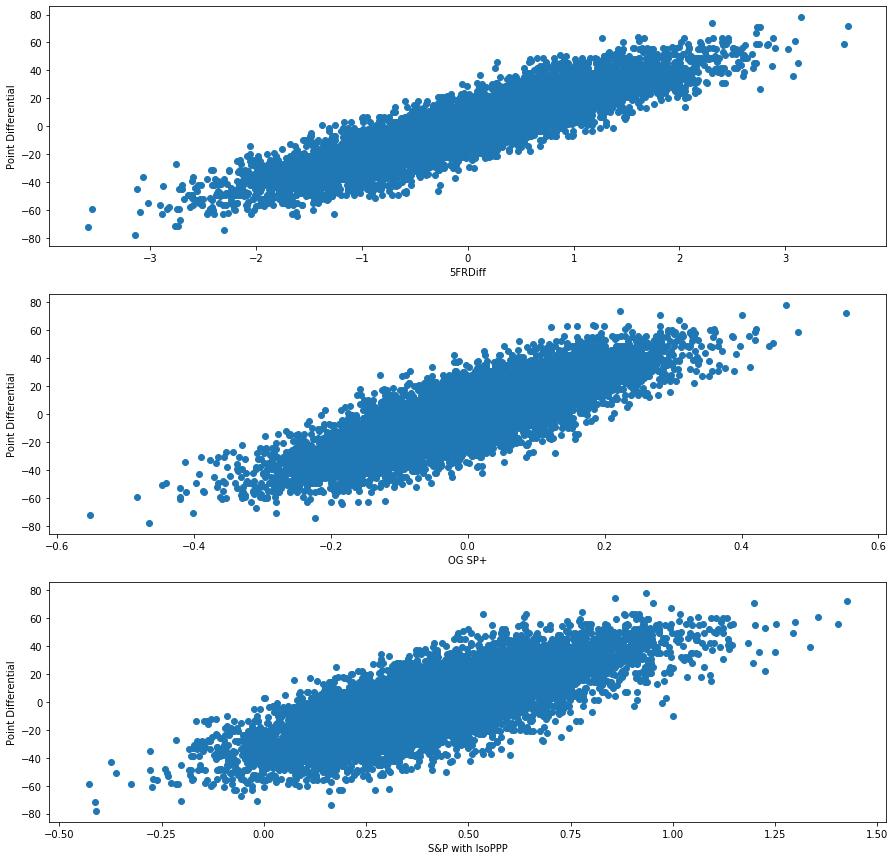

In [14]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [15]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.912285,0.757657
S&PIsoPPPDiff,0.912285,1.000000,0.814933
PtsDiff,0.757657,0.814933,1.000000


In [16]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.436102,0.872203,0.943246,1.899151
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.563898,-0.872203,0.943246,1.899151
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.208914,0.417828,0.451861,0.180871
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.791086,-0.417828,0.451861,0.180871
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.731171,-0.537657,0.581451,0.497397


In [17]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [18]:
# outliers

In [19]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,-0.22,0,0.122680,4.387538,0.04152,0.006633,5.436102,0.872203,0.943246,1.899151
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,0.22,0,-0.122680,-4.387538,-0.04152,-0.006633,4.563898,-0.872203,0.943246,1.899151
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.22,0,0.017305,2.138834,-0.42232,0.042920,5.208914,0.417828,0.451861,0.180871
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.22,0,-0.017305,-2.138834,0.42232,-0.042920,4.791086,-0.417828,0.451861,0.180871
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.00,0,0.087917,-6.578618,0.26167,0.059391,4.731171,-0.537657,0.581451,0.497397


In [20]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [23]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 21.32763x + 0.01299
Mean Pred Score: -0.3669991488573935
Pred Std Dev: 19.686505197224434
Mean Abs Error: 8.033319480063554
Mdn Abs Error: 6.6058438589236
R-squared: 0.7903561134114158



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.759208,0.570769,0.487731,0.794299,0.622677,0.604013,0.963308,0.536014,0.771744,-0.507917,-0.475540,0.717642,0.744428,0.231708,0.556339,0.889025,0.889025,0.889025
OffSRDiff,0.759208,1.000000,0.485366,0.273345,0.690217,0.425797,0.439451,0.745896,0.751160,0.720090,-0.328649,-0.186313,0.634845,0.765426,-0.058041,0.576510,0.847289,0.847289,0.847289
OffERDiff,0.570769,0.485366,1.000000,0.150154,0.495801,0.323050,0.339046,0.553632,0.371890,0.809680,-0.208288,-0.107909,0.758500,0.611009,0.555874,0.198001,0.487324,0.487324,0.487324
FPDiff,0.487731,0.273345,0.150154,1.000000,0.610719,0.100918,0.087765,0.456162,0.037686,0.226791,-0.314579,-0.382315,0.215927,0.203807,0.015819,0.250334,0.581250,0.581250,0.581250
OppRateDiff,0.794299,0.690217,0.495801,0.610719,1.000000,0.240657,0.224052,0.778345,0.288947,0.670568,-0.340821,-0.304415,0.592886,0.730844,0.138746,0.511935,0.798471,0.798471,0.798471
OppEffDiff,0.622677,0.425797,0.323050,0.100918,0.240657,1.000000,0.731024,0.594867,0.534914,0.454645,-0.367044,-0.348521,0.428481,0.390569,0.172728,0.339480,0.519107,0.519107,0.519107
OppPPDDiff,0.604013,0.439451,0.339046,0.087765,0.224052,0.731024,1.000000,0.571657,0.538482,0.483299,-0.359873,-0.336176,0.463777,0.400326,0.201122,0.369232,0.559700,0.559700,0.559700
PPDDiff,0.963308,0.745896,0.553632,0.456162,0.778345,0.594867,0.571657,1.000000,0.530166,0.745263,-0.481378,-0.441583,0.691249,0.705797,0.212962,0.546110,0.857368,0.857368,0.857368
OppSRDiff,0.536014,0.751160,0.371890,0.037686,0.288947,0.534914,0.538482,0.530166,1.000000,0.541114,-0.285087,-0.151464,0.490861,0.486799,-0.015343,0.408293,0.617529,0.617529,0.617529
YPPDiff,0.771744,0.720090,0.809680,0.226791,0.670568,0.454645,0.483299,0.745263,0.541114,1.000000,-0.346105,-0.193730,0.917141,0.804394,0.522791,0.450176,0.704261,0.704261,0.704261


In [24]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['LinearPredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,LinearPredPtsDiff
ActPtsDiff,1.000000,0.767717,0.759208,0.717642,0.901488,0.487731,0.325423,0.889025,0.889025,0.889025
ActPts,0.767717,1.000000,0.586837,0.562477,0.694526,0.382379,0.243100,0.685444,0.685444,0.685444
Eff,0.759208,0.586837,1.000000,0.634845,0.797483,0.273345,0.067996,0.847289,0.847289,0.847289
Expl,0.717642,0.562477,0.634845,1.000000,0.698235,0.215927,0.075775,0.646640,0.646640,0.646640
FinDrv,0.901488,0.694526,0.797483,0.698235,1.000000,0.420457,0.249984,0.897673,0.897673,0.897673
FldPos,0.487731,0.382379,0.273345,0.215927,0.420457,1.000000,0.304661,0.581250,0.581250,0.581250
Trnovr,0.325423,0.243100,0.067996,0.075775,0.249984,0.304661,1.000000,0.490975,0.490975,0.490975
5FR,0.889025,0.685444,0.847289,0.646640,0.897673,0.581250,0.490975,1.000000,1.000000,1.000000
5FRDiff,0.889025,0.685444,0.847289,0.646640,0.897673,0.581250,0.490975,1.000000,1.000000,1.000000
LinearPredPtsDiff,0.889025,0.685444,0.847289,0.646640,0.897673,0.581250,0.490975,1.000000,1.000000,1.000000


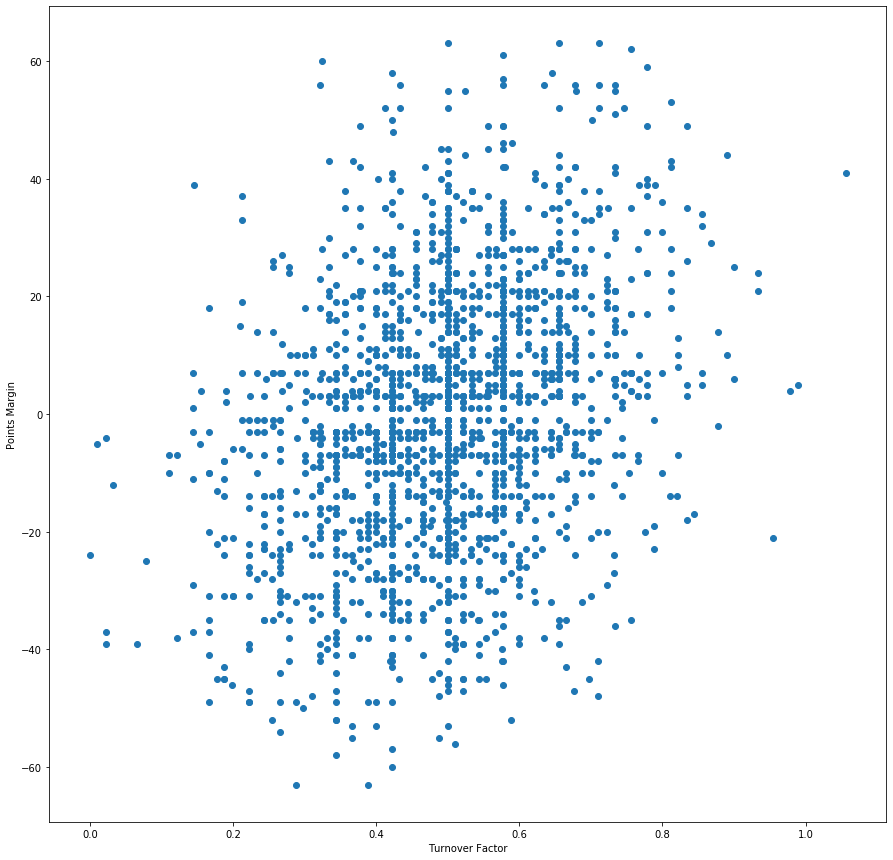

In [25]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

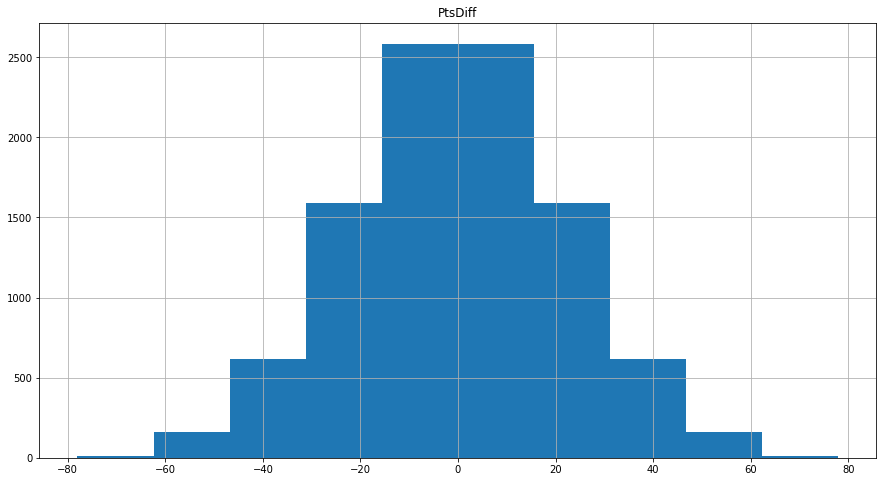

In [26]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

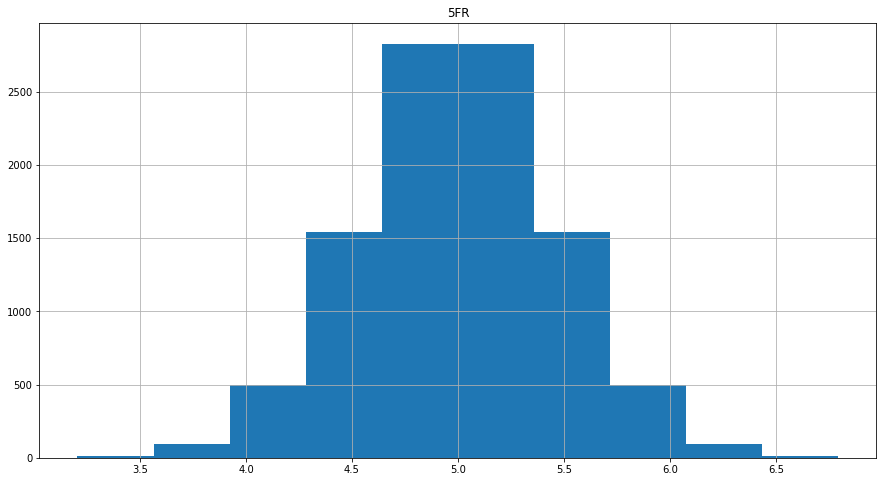

In [27]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

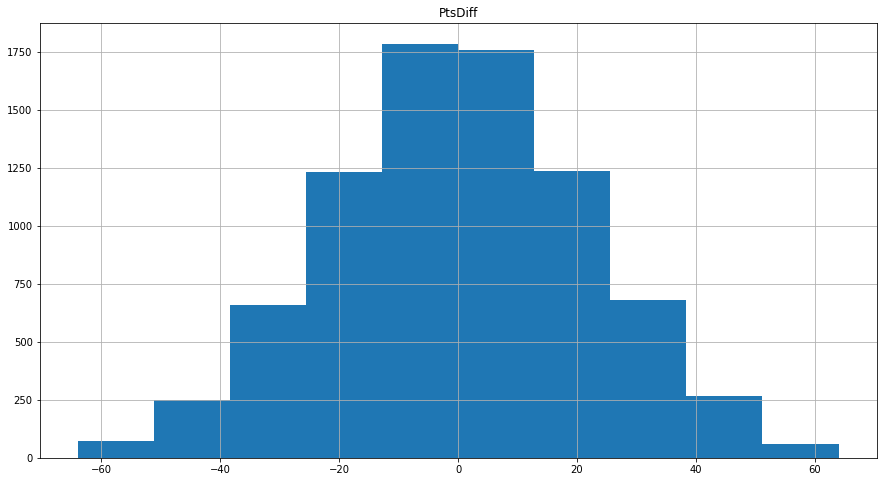

In [28]:
train_data.hist(column='PtsDiff', figsize=(15,8));

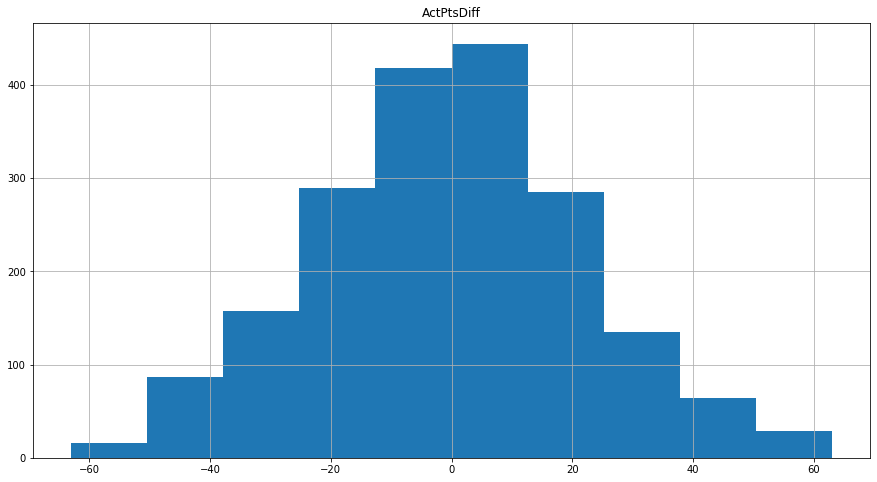

In [29]:
test.hist(column='ActPtsDiff', figsize=(15,8));

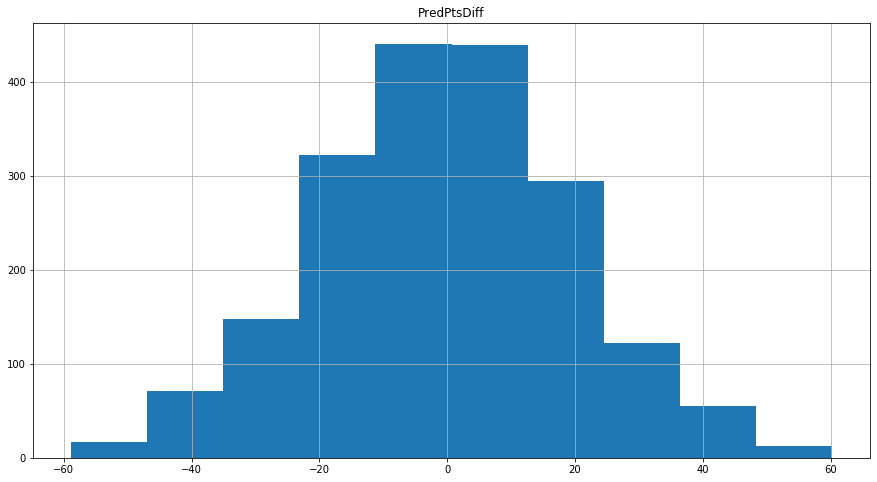

In [30]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [31]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [32]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -4.0 (exact value: -4.373566992499749)
Z score: -0.20351849165220215
Win Prob for Virginia Tech: 41.94%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.118588,0.994779,-0.66,-1,0.103211,2.077885,0.124959,-0.040309,5.102837,0.205675
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.118588,-0.994779,0.66,1,-0.103211,-2.077885,-0.124959,0.040309,4.897163,-0.205675


In [33]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -16.0 (exact value: -15.750287288772773)
Z score: -0.7814128503663638
Win Prob for Georgia Tech: 21.73%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,0.07619,-0.330005,-0.66,1,-0.014422,-0.482035,-0.121075,0.018689,4.630449,-0.739101
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,-0.07619,0.330005,0.66,-1,0.014422,0.482035,0.121075,-0.018689,5.369551,0.739101


In [34]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -6.0 (exact value: -6.388349296572193)
Z score: -0.30586181180414584
Win Prob for Georgia Tech: 37.99%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.01919,-1.322588,0.0,-2,-0.129463,1.273286,-0.300725,0.012719,5.150071,0.300143
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.01919,1.322588,0.0,2,0.129463,-1.273286,0.300725,-0.012719,4.849929,-0.300143


In [35]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 6.0 (exact value: 5.6306705357075435)
Z score: 0.3046589338472599
Win Prob for Mississippi State: 61.97%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,0.880173,...,-0.059649,0.080622,0.22,1,0.020976,6.298842,0.092249,0.000243,4.8683,-0.263399
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,0.059649,-0.080622,-0.22,-1,-0.020976,-6.298842,-0.092249,-0.000243,5.1317,0.263399


In [36]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -8.0 (exact value: -7.955983294076596)
Z score: -0.38549168931665734
Win Prob for Texas A&M: 34.99%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,0.014666,0.876496,0.0,-1,-0.103285,-15.374294,-0.349878,0.001282,5.186823,0.373645
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,-0.014666,-0.876496,0.0,1,0.103285,15.374294,0.349878,-0.001282,4.813177,-0.373645


In [37]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.937765,13,12.0,1.0
2,Clemson,0.932294,13,12.0,1.0
3,Alabama,0.920034,12,11.0,1.0
4,LSU,0.907734,13,12.0,1.0
5,Wisconsin,0.846923,13,11.0,2.0
...,...,...,...,...,...
126,Bowling Green,0.138668,12,2.0,10.0
127,UMass,0.113351,12,1.0,11.0
128,Akron,0.105050,12,1.0,11.0
129,Rutgers,0.100809,12,1.0,11.0


In [38]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.297159,1.702841
21,Clemson,10.537156,2.462844
53,LSU,10.359538,2.640462
2,Alabama,9.334602,2.665398
128,Wisconsin,9.302457,3.697543
...,...,...,...
25,Connecticut,2.142483,9.857517
1,Akron,2.072027,9.927973
112,UMass,2.059338,9.940662
103,Texas State,2.056683,9.943317


In [39]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.606624,1.0
1,Florida State,2012,5.456845,2.0
2,Fresno State,2012,5.371180,3.0
3,Arizona State,2012,5.339381,4.0
4,Oklahoma,2012,5.339329,5.0
...,...,...,...,...
897,Connecticut,2019,4.497653,126.0
898,Bowling Green,2019,4.489725,127.0
899,UMass,2019,4.433154,128.0
900,Akron,2019,4.412666,129.0


In [40]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    team_games = stored_game_boxes[stored_game_boxes.Team == team].GameID.to_list()
    for idx, item in enumerate(team_games, start=1):
        box = stored_game_boxes[stored_game_boxes.GameID == item]
        opp = filter_opponents(box, team)
        opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
...,...,...,...,...,...
9864,401117533.0,Nevada,2019.0,Wyoming,71.0
9865,401117541.0,Boise State,2019.0,Wyoming,72.0
9866,401117546.0,Utah State,2019.0,Wyoming,73.0
9867,401117550.0,Colorado State,2019.0,Wyoming,74.0


In [41]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
        
#     print(grouped_by_year.get_group((team1, year))[:1].tail(4))
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.15166301290243794, -20.63085107060649]

In [42]:
team_triples = [
#     ['Buffalo', 'Charlotte', 7], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17], # App 31, UAB 17
#     ['UCF','Marshall',15], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2], # Hawaii 38, BYU 34
#    ----- 7-3 ML / 5-5 ATS ------
#     ['Miami','Louisiana Tech',6], # LaTech 14, Miami 0
#     ['Pittsburgh','Eastern Michigan',11], # Pitt 34, EMU 30
#    ----- 8-4 ML / 6-6 ATS ------ 
#     ['North Carolina','Temple',5], # UNC 55, Temple 13
    ['Michigan State','Wake Forest',3.5],
    ['Texas A&M', 'Oklahoma State', 7],
    ['Iowa', 'USC', 2.5],
    ['Air Force', 'Washington State', 3],
    ['Penn State','Memphis',7], # Cotton Bowl
    ['Notre Dame', 'Iowa State', 4],
    ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl
    ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl
    ['Western Kentucky', 'Western Michigan', 3.5],
    ['Mississippi State', 'Louisville', 4],
    ['California', 'Illinois', 6.5],
    ['Florida','Virginia',14], # Orange Bowl
    ['Virginia Tech', 'Kentucky', 3],
    ['Arizona State', 'Florida State', 4],
    ['Navy', 'Kansas State', 2],
    ['Wyoming', 'Georgia State', 7],
    ['Utah', 'Texas', 7],
    ['Auburn', 'Minnesota', 7.5],
    ['Alabama', 'Michigan', 7],
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5], # Sugar Bowl
    ['Cincinnati', 'Boston College',7],
    ['Tennessee', 'Indiana', 1.5],
    ['Ohio', 'Nevada', 7.5],
    ['Tulane', 'Southern Mississippi', 7],
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,North Carolina,Temple,5.0,-2.093934,0.465049,False,Temple,Temple
0,Michigan State,Wake Forest,3.5,13.995667,0.767173,True,Michigan State,Michigan State
0,Texas A&M,Oklahoma State,7.0,1.265182,0.533038,False,Texas A&M,Oklahoma State
0,Iowa,USC,2.5,3.311067,0.574104,True,Iowa,Iowa
0,Air Force,Washington State,3.0,2.130265,0.550471,False,Air Force,Washington State
0,Penn State,Memphis,7.0,-0.197204,0.503441,False,Memphis,Memphis
0,Notre Dame,Iowa State,4.0,8.051470,0.665538,True,Notre Dame,Notre Dame
0,LSU,Oklahoma,11.0,10.057345,0.701777,False,LSU,Oklahoma
0,Clemson,Ohio State,2.5,6.581618,0.637942,True,Clemson,Clemson
0,Western Kentucky,Western Michigan,3.5,6.782518,0.641760,True,Western Kentucky,Western Kentucky


In [43]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 6.0 (exact value: 6.211087842882181)
Z score: 0.3341419376287777
Win Prob for Virginia: 63.09%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,0.073684,-2.332187,0.66,3,-0.135068,2.373916,-0.403644,-0.089435,4.854693,-0.290614
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,-0.073684,2.332187,-0.66,-3,0.135068,-2.373916,0.403644,0.089435,5.145307,0.290614


In [44]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 12.0 (exact value: 11.960060064893105)
Z score: 0.6261679810740847
Win Prob for North Carolina: 73.44%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.123887,-0.349659,0.0,-1,-0.01403,15.633715,-0.235394,0.079888,5.280084,0.560169
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.123887,0.349659,0.0,1,0.01403,-15.633715,0.235394,-0.079888,4.719916,-0.560169


In [45]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 14.0 (exact value: 14.414451000535516)
Z score: 0.7508417568943075
Win Prob for Pittsburgh: 77.36%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,0.20743,1.49512,0.0,1,0.130501,14.249196,-0.248736,0.038746,5.337625,0.675249
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,-0.20743,-1.49512,0.0,-1,-0.130501,-14.249196,0.248736,-0.038746,4.662375,-0.675249


In [46]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -8.0 (exact value: -7.795703144447813)
Z score: -0.37735006397365944
Win Prob for Auburn: 35.30%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,0.114729,1.117419,0.44,1,0.063274,9.532495,-0.083465,-0.033763,5.183065,0.36613
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,-0.114729,-1.117419,-0.44,-1,-0.063274,-9.532495,0.083465,0.033763,4.816935,-0.36613


In [47]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 26.0 (exact value: 25.94085498105913)
Z score: 1.3363394805912843
Win Prob for Georgia: 90.93%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,OppSRDiff,YPPDiff,ExpTODiff,ActualTODiff,AvgEqPPPDiff,TotalEqPPPDiff,IsoPPPDiff,HavocRateDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,-0.047059,4.45067,0.0,2,0.330151,25.998278,0.455922,0.020115,5.607847,1.215694
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,0.047059,-4.45067,0.0,-2,-0.330151,-25.998278,-0.455922,-0.020115,4.392153,-1.215694


In [48]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 20.0 (exact value: 19.50598046165697)
Z score: 1.0094721948574306
Win Prob for Clemson: 84.36%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 4.0 (exact value: 4.466806039640928)
Z score: 0.24553901975348227
Win Prob for Georgia Tech: 59.70%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -13.0 (exact value: -12.94241894000094)
Z score: -0.6387837589841254
Win Prob for The Citadel: 26.15%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 26.0 (exact value: 25.676036534180167)
Z score: 1.322887705163094
Win Prob for Temple: 90.71%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 12.0 (exact value: 11.960060064893105)
Z score: 0.62616798107408

,GameID,Year,Team,Opponent,PredWinProb,PredMOV,ActualMOV,PostGameWinProb
0,401111653,2019,Georgia Tech,Clemson,20.126974,-16.112465,-38.0,15.637412
1,401112441,2019,Georgia Tech,South Florida,80.447255,16.518232,4.0,59.698045
2,401112452,2019,Georgia Tech,The Citadel,97.157800,37.126115,-3.0,73.851819
3,401112469,2019,Georgia Tech,Temple,45.199284,-2.007745,-22.0,9.293636
4,401112475,2019,Georgia Tech,North Carolina,51.855372,0.548897,-16.0,26.560238
5,401112480,2019,Georgia Tech,Duke,24.301054,-13.347629,-18.0,26.997083
6,401112488,2019,Georgia Tech,Miami,36.997988,-6.167083,7.0,21.727986
7,401112498,2019,Georgia Tech,Pittsburgh,38.694614,-6.022684,-10.0,22.637395
8,401112504,2019,Georgia Tech,Virginia,34.228469,-7.630363,-5.0,19.472019
9,401112511,2019,Georgia Tech,Virginia Tech,14.720611,-21.008133,-45.0,0.146949


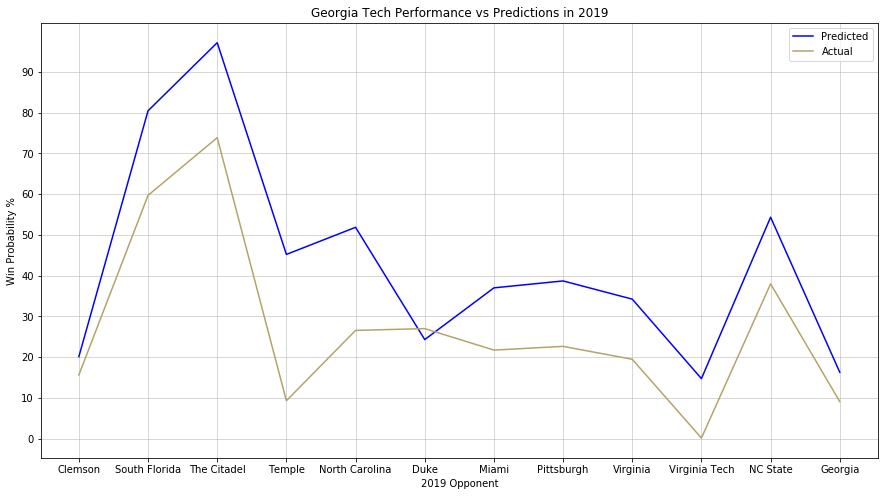

In [49]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

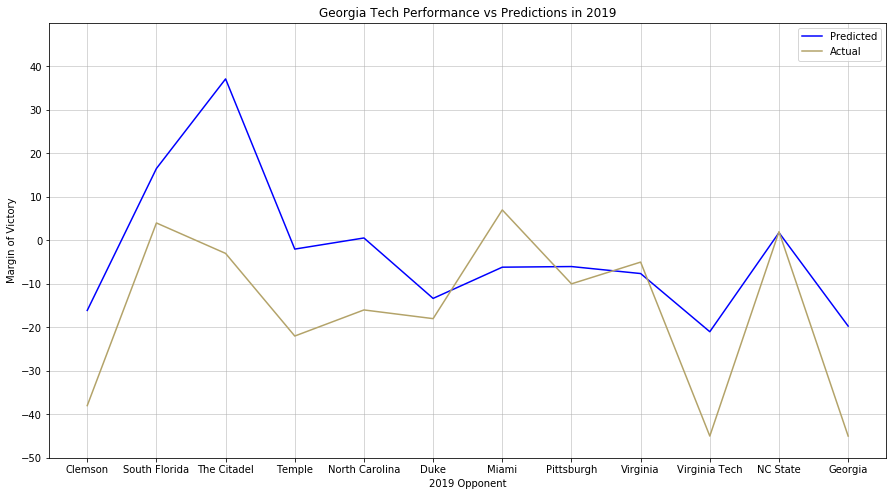

In [50]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 35.0 (exact value: 34.705540902622985)
Z score: 1.7815523730654437
Win Prob for Georgia Tech: 96.26%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 13.0 (exact value: 12.796039475162646)
Z score: 0.668632573031595
Win Prob for South Florida: 74.81%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 11.0 (exact value: 10.5106193101452)
Z score: 0.5525418732287847
Win Prob for Pittsburgh: 70.97%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 29.0 (exact value: 29.136411290042307)
Z score: 1.4986616539262303
Win Prob for Clemson: 93.30%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 38.0 (exact value: 37.93042953955883)
Z sco

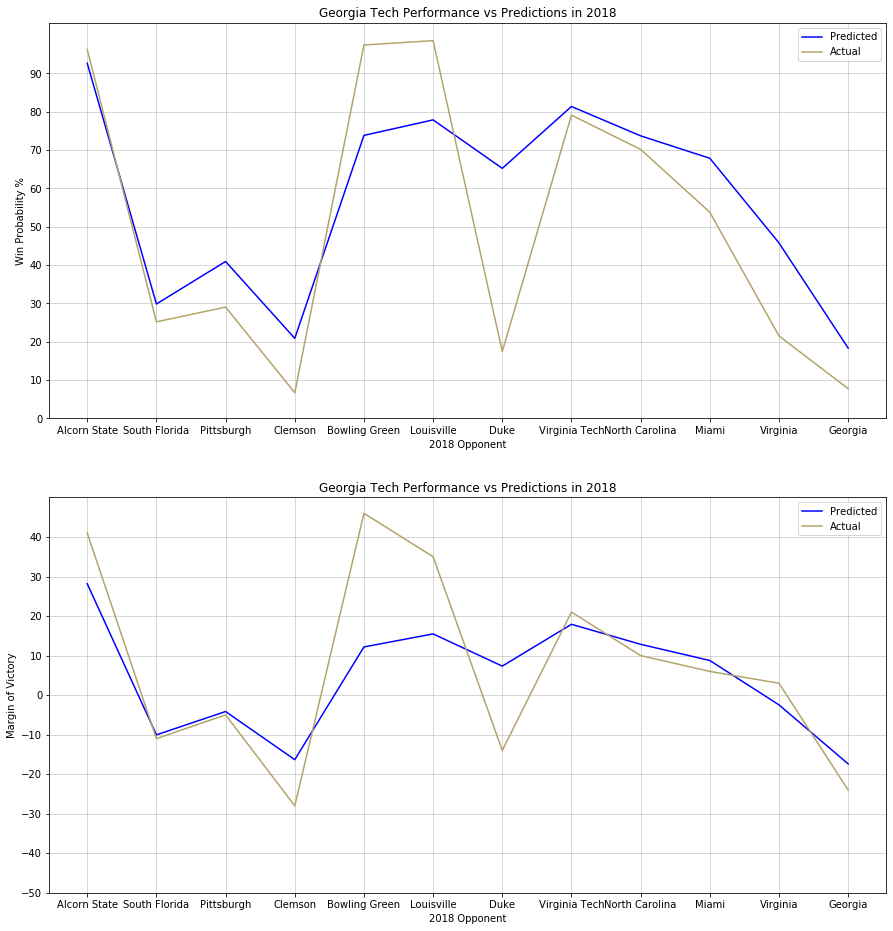

In [51]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

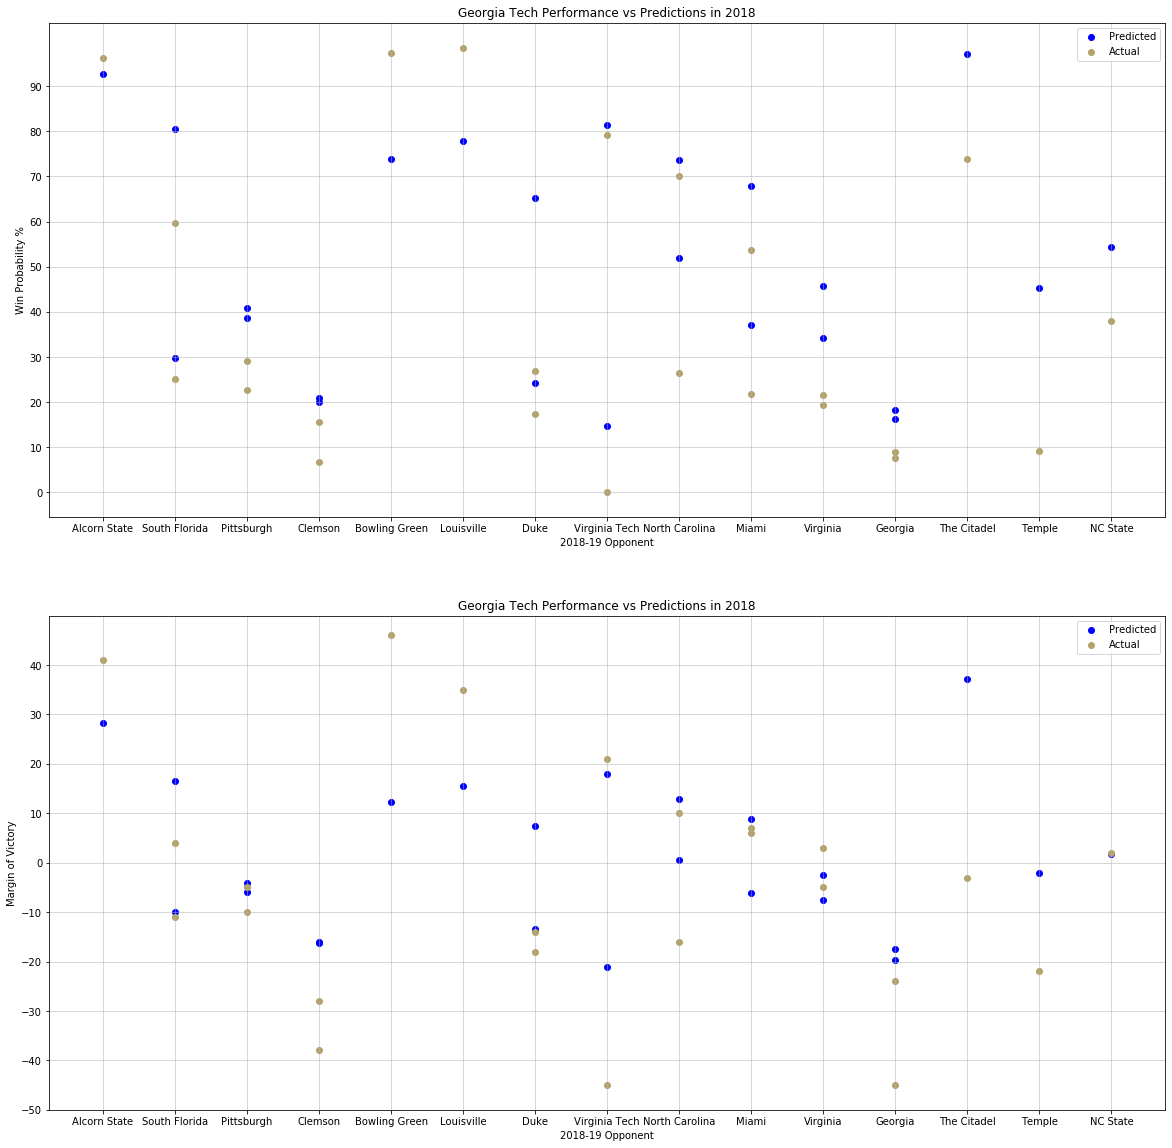

In [52]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [53]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2015,2016,2017,2018,2019
Season,,,,,,,
2012,1.000000,0.581310,0.435028,0.365191,0.286904,0.285329,0.383764
2013,0.581310,1.000000,0.369550,0.250899,0.232639,0.179753,0.281026
2015,0.435028,0.369550,1.000000,0.642715,0.446838,0.345127,0.368099
2016,0.365191,0.250899,0.642715,1.000000,0.567064,0.409997,0.581482
2017,0.286904,0.232639,0.446838,0.567064,1.000000,0.602075,0.539130
2018,0.285329,0.179753,0.345127,0.409997,0.602075,1.000000,0.583893
2019,0.383764,0.281026,0.368099,0.581482,0.539130,0.583893,1.000000


In [54]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["UCF","Auburn","James Madison","Connecticut","Boston College","Duke","Miami","Georgia Tech","NC State","Pittsburgh","Virginia Tech","Virginia"],
    "Site" : ["Away","Home","Home","Home","Away","Away","Away","Home","Home","Home","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("North Carolina", opp_2020_df, 2020)
georgia_tech_2020

,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,North Carolina,UCF,Away,41.167787,-4.761637
1,2020,North Carolina,Auburn,Home,34.276105,-8.338840
2,2020,North Carolina,James Madison,Home,97.680550,38.845300
3,2020,North Carolina,Connecticut,Home,76.107154,13.605570
4,2020,North Carolina,Boston College,Away,49.564059,-0.582126
5,2020,North Carolina,Duke,Away,52.101942,0.670721
6,2020,North Carolina,Miami,Away,39.043438,-5.843531
7,2020,North Carolina,Georgia Tech,Home,63.515547,6.435460
8,2020,North Carolina,NC State,Home,59.512346,4.372420
9,2020,North Carolina,Pittsburgh,Home,52.519941,0.877338


In [55]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)